# AI - CA3 - Naive Bayes - Mohamad Taha Fakharian

## Goal
In this assignment, we're going to design a naive bayes classifier to classify Digimag's dataset. Naive bayes is a good and easy-to-implement classifier and can perform better using smoothing methods.

## Overall approach
To implement naive bayes, we need to specify features and calculate related probabilities for the classifier. Let's start!

In [1]:
# Libraries for preprocessing
from __future__ import unicode_literals
from hazm import *
import nltk
import re

# Libraries for visualiztion
from operator import itemgetter
from bidi.algorithm import get_display
from arabic_reshaper import reshape

# Regular libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Get Familiar with Data
Let's read the train and test dataset and see how they look like:

In [2]:
train_data = pd.read_csv('Data/train.csv', encoding='utf-8')
test_data = pd.read_csv('Data/test.csv', encoding='utf-8')

In [3]:
train_data

,content,label
0,فیلم‌های در حال اکران؛ موزیکال شاد خاله قورباغ...,هنر و سینما
1,پنج فیلمسازی که کوئنتین تارانتینو را عاشق سینم...,هنر و سینما
2,جانی آیو از اپل رفت جانی آیو دیگر نیازی به معر...,علم و تکنولوژی
3,احتمال عدم پشتیبانی iOS ۱۳ از آیفون ۵ اس، SE و...,علم و تکنولوژی
4,دزدان مغازه نماینده ژاپن در اسکار ۲۰۱۹ شد فیلم...,هنر و سینما
...,...,...
5195,امپراطوری اپ (فصل اول/بخش دوم) فصل اول – بخش د...,سلامت و زیبایی
5196,عدم ارتباطات اثربخش و تعارض در محیط کار وجود س...,سلامت و زیبایی
5197,اپل در سال ۲۰۲۰ چهار آیفون معرفی خواهد کرد! طب...,علم و تکنولوژی
5198,مارتینز: بلژیک باید مقابل فرانسه بدون ترس بازی...,سلامت و زیبایی


As you can see, each row in dataset contains a label and a content. Let's see how many different labels are there in dataset and their frequencies:

In [4]:
labels = train_data['label'].unique()

In [5]:
labels

array(['هنر و سینما', 'علم و تکنولوژی', 'سلامت و زیبایی', 'بازی ویدیویی'],
      dtype=object)

In [6]:
labels_frequency = train_data['label'].value_counts()

In [7]:
labels_frequency

هنر و سینما       1300
علم و تکنولوژی    1300
سلامت و زیبایی    1300
بازی ویدیویی      1300
Name: label, dtype: int64

## Phase 1: Preprocessing Data
Let's start with preprocessing step. There are many methods to make data cleaner like stemming, normalizing and lemmatizing. Let's import these preprocessors and see how they perform:

In [8]:
stemmer = Stemmer()
normalizer = Normalizer()
lemmatizer = Lemmatizer()

In [9]:
print(stemmer.stem('خوابیدند'))
print(stemmer.stem('خوابید'))
print(stemmer.stem('خواب'))
print(stemmer.stem('بخوابی'))
print(stemmer.stem('خوابیدم'))

خوابیدند
خوابید
خواب
بخواب
خوابید


In [10]:
print(lemmatizer.lemmatize('خوابیدند'))
print(lemmatizer.lemmatize('خوابید'))
print(lemmatizer.lemmatize('خواب'))
print(lemmatizer.lemmatize('بخوابی'))
print(lemmatizer.lemmatize('خوابیدم'))

خوابید#خواب
خوابید#خواب
خواب
خوابید#خواب
خوابید#خواب


In [11]:
print(normalizer.normalize('اصلاح نويسه ها و استفاده از نیم‌فاصله پردازش را آسان مي كند'))

اصلاح نویسه‌ها و استفاده از نیم‌فاصله پردازش را آسان می‌کند


As you can see, stemming is the process of producing morphological variants of a root/base word. Stemming programs are commonly referred to as stemming algorithms or stemmers. Often when searching text for a certain keyword, it helps if the search returns variations of the word. Stemming is a somewhat crude method for cataloging related words; it essentially chops off letters from the end until the stem is reached.

In contrast to stemming, lemmatization looks beyond word reduction and considers a language’s full vocabulary to apply a morphological analysis to words. Lemmatization is typically seen as much more informative than simple stemming. One thing to note about lemmatization is that it is harder to create a lemmatizer in a new language than it is a stemming algorithm because we require a lot more knowledge about structure of a language in lemmatizers.

Normalizing is typically the process of using both stemming and lemmatization and adding some cleaning methods like replacing space with half space in some words like plural words. 

We need to exclude stop words from the tokens to improve the performance. Punctuations are added in these words. We'll use a set of stop words for persian words, provided in 'stop_words.txt':

In [12]:
flags = {
    'stem' : False,
    'normalize' : False,
    'lemmatize' : True
}

In [13]:
def get_stop_words(file, flags=flags):
    stem = flags['stem']
    lemmatize = flags['lemmatize']
    with open('stop_words.txt', 'r', encoding='utf-8') as stop:
        words = [word.replace('\u200c',' ').strip() for word in stop if word]
    words.extend(['\n', '\r'])
    
    words = list(map(stemmer.stem, words)) if stem else words
    words = list(map(lemmatizer.lemmatize, words)) if lemmatize else words
    return set(words)

In [14]:
stop_words = get_stop_words('stop_words.txt')

In [15]:
stop_words

{'اشتباها',
 'به جز',
 'ضدِّ',
 'درصورتی که',
 'خیلی',
 'بروز',
 'دیده',
 'کی',
 'می خوانید',
 'صد',
 'خیره',
 'اینجاست',
 '۱',
 'نفرند',
 'گرچه',
 'ان شاأالله',
 'ل',
 'قاعدتاً',
 'نخست',
 'به تدریج',
 'طبیعتا',
 'در کنار',
 'صرفاً',
 'ی',
 'طبقِ',
 'ویا',
 'پس فردا',
 'مامان مامان گویان',
 'افسوس',
 'ساده اند',
 'روزانه',
 'باز هم',
 'یک کمی',
 'این قدر',
 'ت',
 'گروهی',
 'سویِ',
 'ه',
 'همواره',
 'هستا',
 'لااقل',
 'می کنم',
 'انصافا',
 'گرفت#گیر',
 'یقینا',
 'بدجور',
 'ا',
 'چنان',
 'کم',
 '۹',
 'معمولی',
 'زیرا',
 '۶',
 'به جای',
 'لیکن',
 'جمع اند',
 'چه',
 'بار',
 'باد',
 'منی',
 'اینقدر',
 'سالانه',
 'شدن',
 'مجموعاً',
 'گویا',
 'آورد#آور',
 'زیاد',
 'برای',
 'هرگاه',
 'دوباره',
 'اما',
 'اگرچه',
 'زود',
 'خواست#خواه',
 'میزان',
 'موقتا',
 'کلیه',
 'فلان',
 'جمعا',
 'مرتب',
 'چشم بسته',
 'خویش',
 'ها',
 'وای',
 'کرده',
 'تماما',
 'لطفاً',
 'مورد',
 'هرکس',
 'همان گونه که',
 'دوم',
 'برنامه سازهاست',
 'فر',
 'ک',
 'ضمناً',
 'ان',
 'به تازگی',
 'باورند',
 'بیش',
 'هیچ جور',
 'از 

Let's put all pieces together. We'll use a 'flags' dictionary to check which operations should be done on data. We use 'word_tokenize' to seperate words from context. Rest is explained above:

In [16]:
def preprocess(data, flags=flags):
    stem = flags['stem']
    normalize = flags['normalize']
    lemmatize = flags['lemmatize']
    
    clean_data = str(data).replace('\u200c',' ')
    clean_data = normalizer.normalize(clean_data) if normalize else clean_data
    
    words = word_tokenize(clean_data)
    
    words = list(map(stemmer.stem, words)) if stem else words
    words = list(map(lemmatizer.lemmatize, words)) if lemmatize else words
    words = [word for word in words if word not in stop_words]
    
    return words

Let's see the result with an example:

In [17]:
preprocess(train_data['content'][0], flags)

['فیلم',
 'اکران',
 'موزیکال',
 'شاد',
 'خاله',
 'قورباغه',
 'بزرگسالان',
 'بچه',
 'فیلم',
 'خاله',
 'قورباغه',
 'تلویزیون',
 'یاد',
 'کاراکتر',
 'قورباغه',
 'بامزه',
 'پرحرف',
 'دل',
 'مهربان',
 'خرابکاری',
 'خاله',
 'قورباغه',
 'فیلم',
 'کودکانه',
 'گلنار',
 'مخاطب',
 'معرف',
 'دوست',
 'گلنار',
 'پختن',
 'کلوچه',
 'کمک',
 'دل',
 'خرس',
 'خانم',
 'دست',
 'فرار',
 'قصه',
 'فیلم',
 'خاله',
 'قورباغه',
 'خاله',
 'قورباغه',
 'کاراکتر',
 'مهربان',
 'عاشق',
 'معاشرت',
 'همسایه',
 'هایش',
 'خاله',
 'قورباغه',
 '۹۸',
 'بچه',
 'دور',
 'افتاده',
 'دلتنگی',
 'اذیت',
 'خواهر',
 'دوقلو',
 'آبجی',
 'باج',
 'همسایه',
 'خلافکار',
 'حریص',
 'سمسارباشی',
 'دوست',
 'قدیم',
 'نوه',
 'هایش',
 'دیدن',
 'داستان',
 'رقم',
 'خورد#خور',
 'کارگردان',
 'فیلم',
 'خاله',
 'قورباغه',
 'کیست',
 'افشین',
 'هاشم',
 'سال',
 'تئاتر',
 'موزیکال',
 'مفرح',
 'شیر',
 'خان',
 'باباسلطنه',
 'سال',
 'صحنه',
 'کارگردان',
 'فیلم',
 'موزیکال',
 'آبدیده',
 'بازیگر',
 'کارگردان',
 'باسابقه',
 'تئاتر',
 'وارد',
 'سینما',
 'فیلم',
 '

## Phase 2: Problem Process
As mentioned before, a bag-of-words approach in the model. The feature for the classifier is the number of words of each label used in the dataset. Let's see the base formula used in the naive bayes classifier for this problem:
$$P(c|x) = \frac{P(x|c)P(c)}{P(x)}$$

$x$: Words detected as evidence

$c$: Label

$P(c|x)$: Probability of predicting record as label c, knowing words x have appeared in the context as evidence(Posterior Probability)

$P(x|c)$: Probability of words x appear in the contexts with label c(Likelihood)

$P(c)$: Probability of labeling as label c(Class Prior Probability). Typically calculated as the fraction of label c to total labels.

$P(x)$: Probability of seeing words x in the context(Predictor Prior Probability (Evidence)). We don't really need to calculate this probability since it's common in all probabilities we need to calculate

Using the naive bayes assumption that the presence of a particular feature in a class is unrelated to the presence of any other feature and expanding $x$ to $x_1, x_2, \cdots, x_n$ and ignoring $P(x)$, the probability can be calculated as follows:

$$P(c|x) = P(x_1|c)P(x_2|c)\cdots P(x_n|c)P(c)$$

General process steps:
- Preprocess data
- Tokenize data(can be unigram, bigram or ngram)
- Train the classifier
- Test the classifier and check its performance

## Bigram
This part relates to Feature Splitting technique of feature engineering. Using N-gram approach can increase the amount of information captured from context. Note that using unigrams might increase inaccuracy of the model, for example check out the following snetences:
I left my phone in the room.
I'm left alone.
Left here has two meanings and we need to know more than one word in order to figure out what left means.
Persian example:

شیر امید را خورد

امید شیر را خورد

This example is rather difficult! For this one, not only we need to check all the words, but also we need to check their order.
In the first sentence, شیر means lion and the sentence translates to "The lion ate Omid".
But in the second one, شیر means milk! The translation will be: "Omid drank the milk".

Using bigram can help the classifier to increase the accuracy by checking the order and combination of words. Pay attention! Increaing number of words attached together doesn't always increase the accuarcy.

## Check correctness
To check whether the model works fine or not, we plot frequent words for each label to see which words can be influential in classifying task.

Let's implement these functions now:

In [18]:
# To create ngrams
def generate_ngrams(words, n=1):
    ngrams = zip(*[words[i:] for i in range(0, n)])
    return [' '.join(ngram) for ngram in ngrams]

# To fit the model, counting words for each label in dataset
def fit(n=1):
    total = dict(zip(labels, [0 for i in range(len(labels))]))
    per_label = dict(zip(labels, [dict() for i in range(len(labels))]))
    
    for index, row in train_data.iterrows():
        words = preprocess(row['content'])
        ngrams = generate_ngrams(words, n)
        
        label = row['label']
        for ngram in ngrams:
            per_label[label][ngram] = per_label[label].get(ngram, 0) + 1
            total[label] += 1
    model = {
        'total' : total,
        'per_label' : per_label
    }
    return model

# To plot frequent words to check whether model works fine
def plot_frequent_words(model, frequent_num=5):
    per_label = model['per_label']
    figure, axis = plt.subplots(nrows=len(labels), ncols=1, figsize=(15,15), constrained_layout=True)
    figure.supxlabel("Words")
    figure.supylabel("Frequency")
    for i in range(len(labels)):
        frequent = dict(sorted(per_label[labels[i]].items(), key = itemgetter(1), reverse = True)[:frequent_num])
        keys = frequent.keys()
        values = frequent.values()
        axis[i].bar([get_display(reshape(key)) for key in keys], values)
        axis[i].set_title(get_display(reshape(labels[i])))
    plt.show() 

Let's train the model and check it:

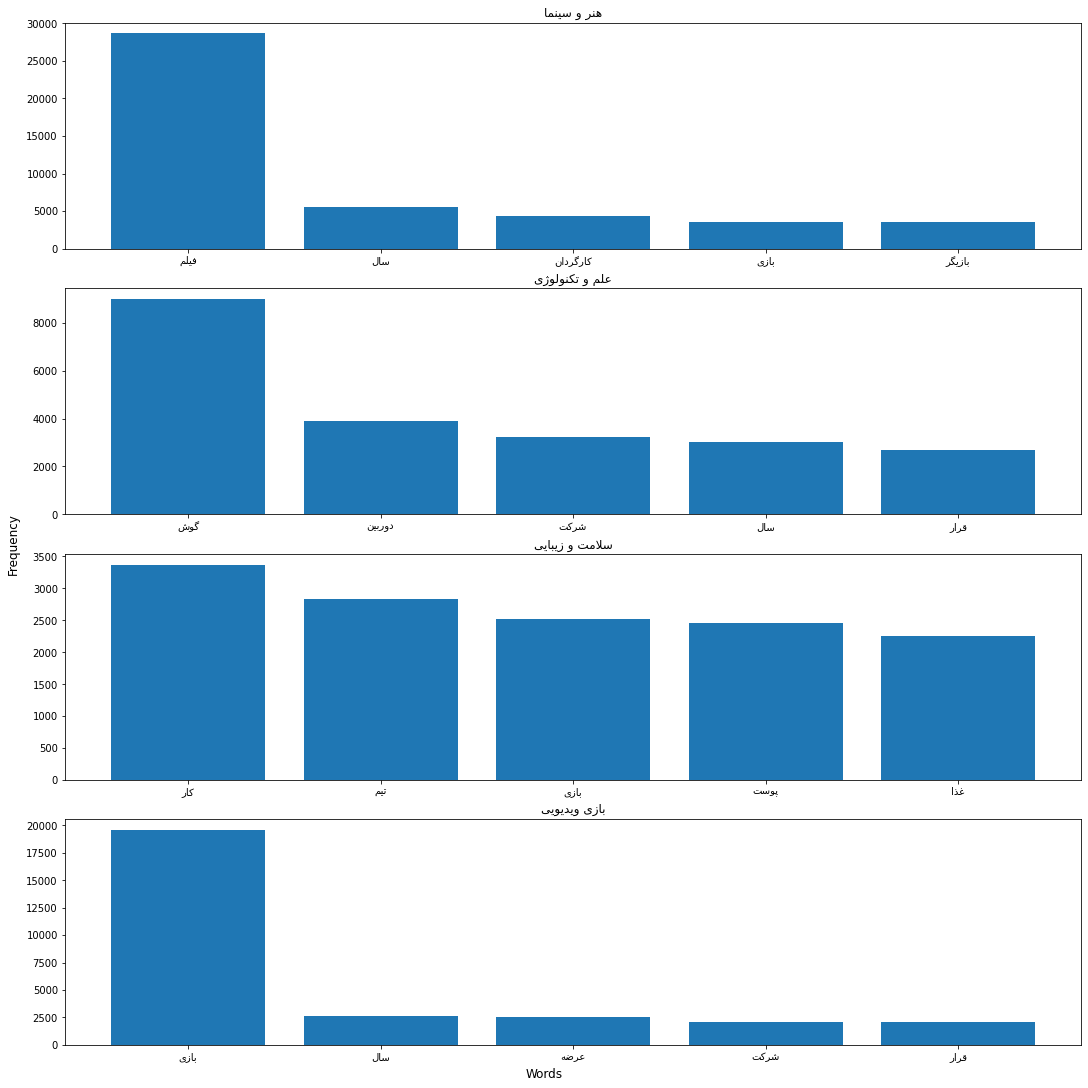

In [19]:
model = fit()
plot_frequent_words(model)

As you can see from the plots, some words are frequent in all labels like 'بازی'. It is better to exclude these words to increase the performance of model:

In [20]:
stop_words.update(['قرار', 'سال', 'بازی'])

Let's train again and check the new model:

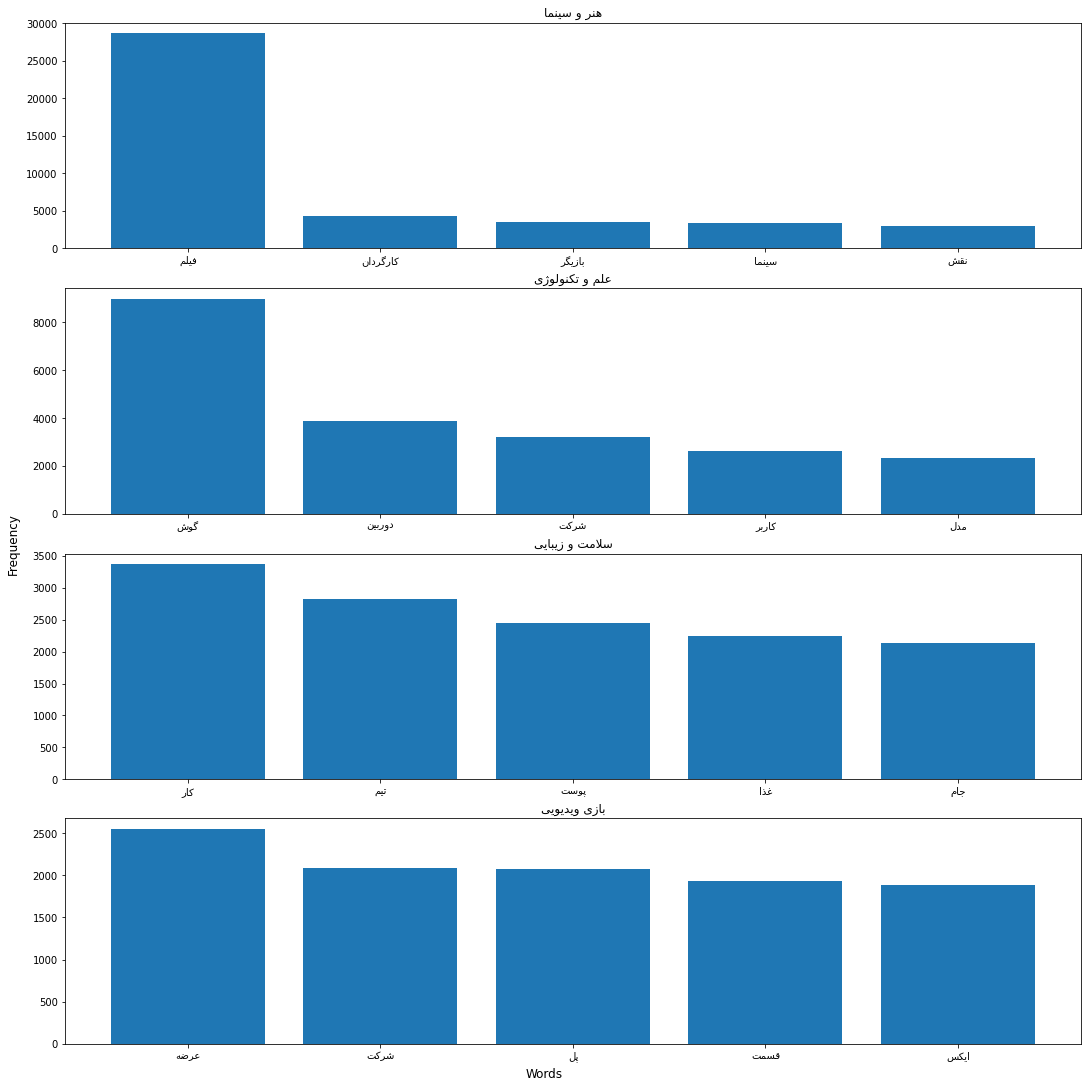

In [21]:
model = fit()
plot_frequent_words(model)

## Additive Smoothing
In case that there is word occured in only one type of label, Naive Bayes will definetly choose that label as the answer which might be wrong in some cases.

When word $x$ hasn't appeared in genre $c$, $P(x|c) = 0$, which will result in $P(c|x) = 0$ and this genre won't be chosen as the answer. A solution is to use additive smoothing instead of regular approach.

Additive smoothing associates the probability as follows:
$$P = \frac{Wordcount + \alpha}{Totalcount + \alpha * D}$$

, where $D$ is the number of features in the test and $\alpha$ is the degree of smoothing. Using this approach will solve the problem of $P = 0$, which will result in giving other labels a chance to be selected in the above scenario.

Let's implement remaining functions for training phase. Instead of calculating probabilities, we calculate scores. This is because probabilities are not high enough to differentiate and product of these small values will be near to zero, which make classifying harder than before. To solve the problem, we use log transform of these values as scores and we pick up the label with highest score among others.

In [22]:
labels_prob = dict(zip(labels, [labels_frequency[label] / np.sum(labels_frequency) for label in labels]))

In [23]:
# To calculate the score for specific label
def calculate_score(model, label, ngrams, alpha=0):
    score = 0
    ZERO = 10**-100
    features = len(ngrams)
    per_label, total = model['per_label'], model['total']
    for ngram in ngrams:
        if not ngram in per_label[label] and alpha == 0:
            score += np.log(ZERO)
        else:
            score += np.log((per_label[label].get(ngram, 0) + alpha) / (total[label] + alpha * features))
        
    score += np.log(labels_prob[label])
    return score

# To predict labels for test data
def predict(model, n=1, alpha=0):
    predicted = test_data.copy(deep=True)
    predictions = np.array([])
    for index, row in predicted.iterrows():
        words = preprocess(row['content'])
        ngrams = generate_ngrams(words, n)
        scores = dict(zip(labels, [calculate_score(model, label, ngrams, alpha) for label in labels])) 
        prediction = max(scores, key=scores.get)
        predictions = np.append(predictions, prediction)
    predicted['predicted_label'] = predictions
    return predicted

Let's see the results for unigram model which uses additive smoothing with $\alpha = 1$:

In [24]:
predicted = predict(model, n=1, alpha=1)

In [25]:
predicted

,content,label,predicted_label
0,با این ۵ صبحانه رژیمی لاغر شوید صبحانه همیشه ب...,سلامت و زیبایی,سلامت و زیبایی
1,نمایشگر گوشی تاشونده ال‌جی مانند بروشور باز و ...,علم و تکنولوژی,علم و تکنولوژی
2,چرا برخی سلبریتی‌های هالیوودی از شبکه‌های اجتم...,هنر و سینما,هنر و سینما
3,گوگل استیدیا؛ آینده‌ی صنعت بازی یا محکوم به شک...,بازی ویدیویی,بازی ویدیویی
4,ویژگی جذاب گلکسی Z Flip به زودی به گوشی‌های ان...,علم و تکنولوژی,علم و تکنولوژی
...,...,...,...
797,برادران داردن با فیلمی درباره افراطی‎گری به کن...,هنر و سینما,هنر و سینما
798,Death Stranding پر از میان‌پرده‌های طولانی است...,بازی ویدیویی,بازی ویدیویی
799,حالت نیو گیم پلاس به اسپایدرمن اضافه می‌شود چن...,بازی ویدیویی,بازی ویدیویی
800,چگونه مثل جف بزوس هک نشویم؛ ۵ توصیه امنیتی برا...,علم و تکنولوژی,علم و تکنولوژی


## Phase 3: Test
Now we'll test our algorithms accuracy and see if we can improve it or not.
In order to test it we'll need to check the following criteria:
- Accuracy

$$Accuracy = \frac{Correct Detected}{Total}$$

- Precision

$$Precision = \frac{Correct Detected Label}{All Detected Label}$$

- Recall

$$Recall = \frac{Correct Detected Label}{All Label}$$

- F1

$$F1 = 2 * \frac{Precision * Recall}{Precision + Recall}$$

## Why we use both precision and recall in checking the algorithm:

1. If the classifier always predicts the same label for a label, the recall value for the that label will be 100% which will inform us that the model isn't adequate.

2. There might be a case that we only have 2 predictions for a specific out of a total number of 500000 predictions. The probability of making a mistake in two predictions would be so low because we made only 2 predictions. So this might lead to a 100% precision and a low recall because of missing many other instances of that label.

## F1 Score
F1 score is the harmonic mean of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall.

## Multi-Class Metrics
In this model, we have three different types of averaging methods:

Micro: Calculates F1 by value total true positives, false negatives and false positives no matter the prediction for each label in the dataset. 

$$Micro-F1 = \frac{CorrectDetected}{AllDetected}$$

Macro: Calculates F1 for each label, and returns the average without considering the proportion for each label in the dataset.
 
$$Micro-F1 = \frac{F1_1 + F1_2 + \cdots + F1_n}{n}$$

Weighted: Calculates F1 for each label, and returns the average considering the proportion for each label in the dataset.

$$Weighted-F1 = P(C_1)F1_1 + \cdots + P(C_n)F1_n$$

Since our categories are balanced, the result of weighted and macro averages won't be different.

Let's implement it!

In [26]:
def measure(predicted):
    measures = pd.DataFrame(columns=np.append(labels,'Total'), 
                            index=['Precision', 'Recall', 'F1-score', 'Accuracy', 'Macro Avg',
                                  'Micro Avg', 'Weighted Avg'])
    F1 = {}
    per_label = {}
    for label in labels:
        all_label = predicted[predicted['label'] == label]
        correct = all_label[all_label['predicted_label'] == label]
        all_predicted = predicted[predicted['predicted_label'] == label]
        per_label[label] = len(all_label)
        
        precision = len(correct) / len(all_predicted)
        recall = len(correct) / len(all_label)
        f1 = (2 * precision * recall) / (precision + recall)
        F1[label] = f1
        
        measures.loc['Precision', label] = precision * 100
        measures.loc['Recall', label] = recall * 100
        measures.loc['F1-score', label] = f1 * 100
        
    total_corrected = predicted[predicted['label'] == predicted['predicted_label']]
    measures.loc['Accuracy', 'Total'] = len(total_corrected) / len(predicted)
    measures.loc['Macro Avg', 'Total'] = np.mean(list(F1.values()))
    measures.loc['Micro Avg', 'Total'] = measures.loc['Accuracy', 'Total']
    measures.loc['Weighted Avg', 'Total'] = np.sum([per_label[label] / len(predicted) * F1[label] for label in labels])
    measures.fillna('-', inplace=True)
    return measures

Let's see the meaures for the unigram model with and without additive smoothing:

In [27]:
no_smoothing = predict(model, n=1, alpha=0)
measure(no_smoothing)

,هنر و سینما,علم و تکنولوژی,سلامت و زیبایی,بازی ویدیویی,Total
Precision,88.297872,96.212121,88.757396,98.895028,-
Recall,99.401198,91.696751,93.167702,90.862944,-
F1-score,93.521127,93.900185,90.909091,94.708995,-
Accuracy,-,-,-,-,0.933915
Macro Avg,-,-,-,-,0.932598
Micro Avg,-,-,-,-,0.933915
Weighted Avg,-,-,-,-,0.934195


In [28]:
measure(predicted)

,هنر و سینما,علم و تکنولوژی,سلامت و زیبایی,بازی ویدیویی,Total
Precision,95.857988,95.714286,95.652174,96.875,-
Recall,97.005988,96.750903,95.652174,94.416244,-
F1-score,96.428571,96.229803,95.652174,95.62982,-
Accuracy,-,-,-,-,0.9601
Macro Avg,-,-,-,-,0.959851
Micro Avg,-,-,-,-,0.9601
Weighted Avg,-,-,-,-,0.960079


As you can see, there is an improvement in accuracy if we use smoothing in our model. Best result is for Cinema label and worst result is for Game and Health label.

Let's take a look at rows that are predicted with wrong label:

In [29]:
wrong_predicted = predicted[predicted['label'] != predicted['predicted_label']]

In [30]:
wrong_predicted

,content,label,predicted_label
50,دیزنی به کمک دوربین‌های نوکیا، محتوای واقعیت م...,هنر و سینما,علم و تکنولوژی
53,Ryzen Threadripper: قوی‌ترین پردازنده‌های AMD ...,بازی ویدیویی,علم و تکنولوژی
173,همه چیز درباره ارزش پول (داستان پول – قسمت ۵) ...,علم و تکنولوژی,بازی ویدیویی
202,تریلر جدید سریال The Walking Dead مقدمه‌ای برا...,هنر و سینما,بازی ویدیویی
305,بهترین ترکیب‌های PES ۲۰۲۰ کدام هستند؟ اگر اهل ...,بازی ویدیویی,سلامت و زیبایی
328,اصغر قندچی؛ مستند آن مرد با ماک آمد (قسمت دوم)...,علم و تکنولوژی,هنر و سینما
357,لگوی Ghost Busters از تابستان وارد بازار می‌شو...,سلامت و زیبایی,هنر و سینما
371,توفان بتمن و سوپرمن در کامیک‌کان دنیای ابرقهرم...,هنر و سینما,بازی ویدیویی
381,بت موبیل فروشی شد؛ خودرو بت من با موتور جت و م...,علم و تکنولوژی,هنر و سینما
384,گوشی مخصوص بازی Razer معرفی شد اگر به بازی‌های...,بازی ویدیویی,علم و تکنولوژی


As mentioned before, most of our errors are related to fGame and Health labels. This is partially because of our pre processing and the nature of these two labels. If we take a look at the most occured words in these two categories, we'll see that these two have the most number of words that have occured in other categories which is one of the reasons why they are the least accurate. So we might fix our pre processing by adding more stop words or checking some other features.

## Optional: Bigram model
Let's train a bigram model and see if there is an improvement in the results or not:

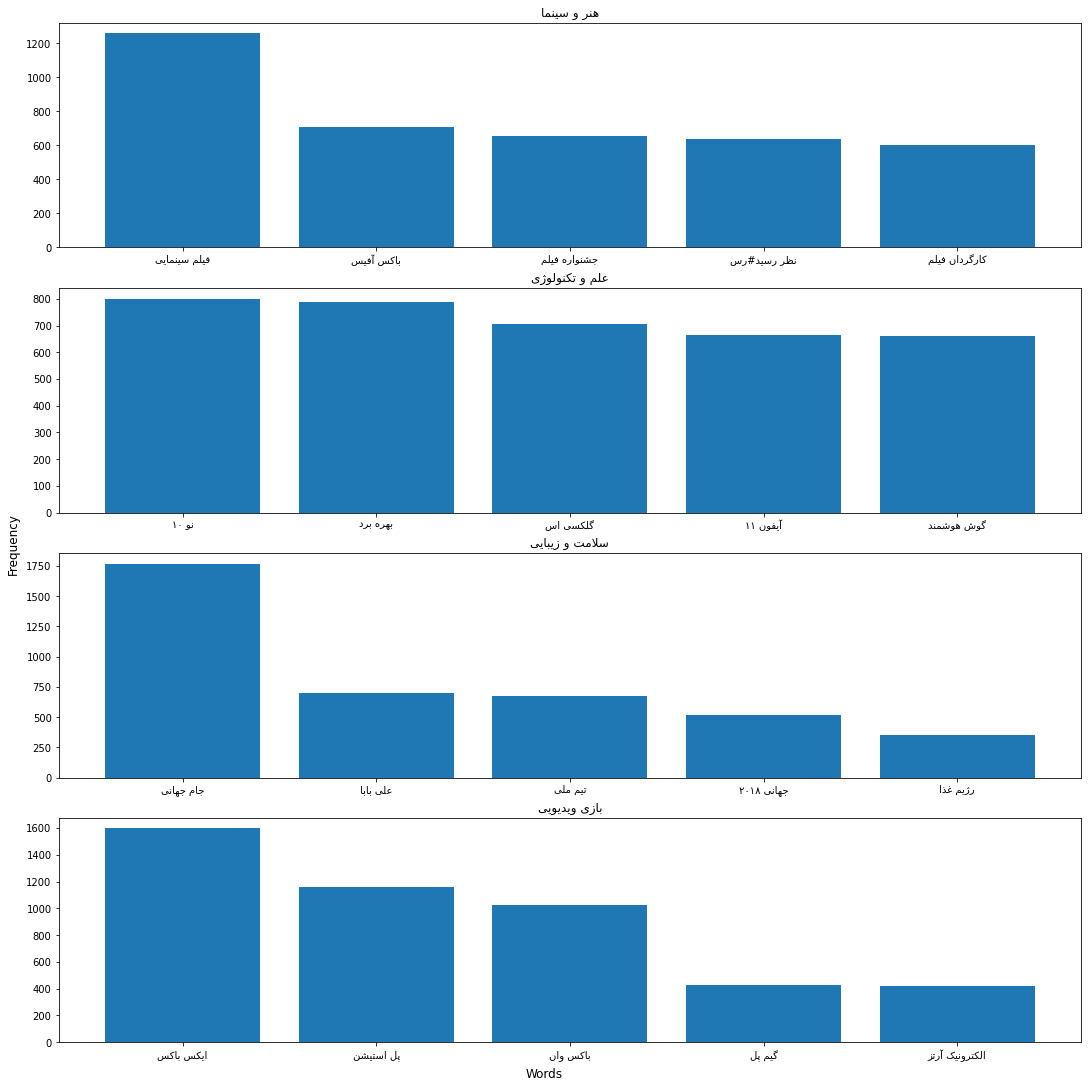

In [31]:
bigram_model = fit(n=2)
plot_frequent_words(bigram_model)

In [32]:
measure(predict(bigram_model, n=2, alpha=0))

,هنر و سینما,علم و تکنولوژی,سلامت و زیبایی,بازی ویدیویی,Total
Precision,95.930233,97.090909,92.857143,99.465241,-
Recall,98.802395,96.389892,96.89441,94.416244,-
F1-score,97.345133,96.73913,94.832827,96.875,-
Accuracy,-,-,-,-,0.965087
Macro Avg,-,-,-,-,0.96448
Micro Avg,-,-,-,-,0.965087
Weighted Avg,-,-,-,-,0.96516


As you can see, there is an improvement in the model.

# Conclusion
Naive Bayes model is easy to build and particularly useful for very large data sets. Along with simplicity, Naive Bayes is known to outperform even highly sophisticated classification methods.

- If continuous features do not have normal distribution, we should use transformation or different methods to convert it in normal distribution.
- If test data set has zero frequency issue, apply smoothing techniques “Laplace Correction” to predict the class of test data set.
- Remove correlated features, as the highly correlated features are voted twice in the model and it can lead to over inflating importance.
- You might think to apply some classifier combination technique like ensembling, bagging and boosting but these methods would not help. Actually, “ensembling, boosting, bagging” won’t help since their purpose is to reduce variance. Naive Bayes has no variance to minimize.